In [25]:
import pandas as pd
import quandl as qd
import math
import numpy as np

In [4]:
df = qd.get('WIKI/GOOGL')
df.head()


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [5]:
df = df[['Adj. High', 'Adj. Low', 'Adj. Open', 'Adj. Close', 'Adj. Volume']]

df['HL_PCT'] = ( df['Adj. High'] - df['Adj. Close'] )/df['Adj. Close']*100

df['PCT_change'] = ( df['Adj. Close'] - df['Adj. Open'] )/df['Adj. Open']*100

In [6]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume'] ]

In [7]:
forecast_col = 'Adj. Close'

df.fillna(-9999, inplace=True)  # fill vacancies

In [8]:
forecast_out = int(math.ceil(0.01*len(df)))  

print(forecast_out)

35


In [9]:
df['label'] = df[forecast_col].shift(-forecast_out) #.shift()
df.dropna(inplace=True)


In [10]:
from sklearn import preprocessing,svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

list(df)

['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume', 'label']

In [11]:
X = np.array(df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']])   # all column except label
X = preprocessing.scale(X)

X_upto = X[:-forecast_out]     #upto given data
x_late = X[-forecast_out:]  # future

df.dropna(inplace=True)

y = np.array(df['label'][:-forecast_out])
y = np.array(df['label'])



In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

print(len(X_train), len(X_test))

2711 678


In [13]:
clf = LinearRegression()
# clf = LinearRegression(n_jobs=-1)  #n_jobs default = 1

# clf = svm.SVR()
# clf = svm.SVR(kernel='poly')

clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

print(accuracy)

0.9759859692616516


In [14]:
forecast_set = clf.predict(x_late)
print(forecast_set, accuracy)

[1075.42764164 1089.88976284 1103.8043972  1098.49465482 1092.06797736
 1089.42870707 1087.77480063 1084.74674558 1078.68422762 1074.34520107
 1071.95649156 1091.4134437  1109.80510009 1114.32075499 1129.10720444
 1133.13893603 1131.78327146 1129.25786721 1131.04018358 1149.37852402
 1148.81831916 1158.53330565 1155.18687998 1162.88137427 1183.19960407
 1195.519307   1190.02794502 1201.74512679 1207.2357597  1205.50895074
 1196.27065819 1201.71113513 1200.38804285 1136.19925188 1083.85077971] 0.9759859692616516


In [15]:
# graph reresentation of future predictions

import matplotlib.pyplot as plt
from matplotlib import style
import datetime
%matplotlib inline
import mpld3
mpld3.enable_notebook()
style.use('ggplot')

In [16]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()

one_day = 86400
next_unix = last_unix + one_day

In [17]:
df['forecast'] = np.nan

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i] #set nan for all columns except last + forecast

print(df.tail())
    

                     Adj. Close  HL_PCT  PCT_change  Adj. Volume  label  \
Date                                                                      
2018-03-08 05:30:00         NaN     NaN         NaN          NaN    NaN   
2018-03-09 05:30:00         NaN     NaN         NaN          NaN    NaN   
2018-03-10 05:30:00         NaN     NaN         NaN          NaN    NaN   
2018-03-11 05:30:00         NaN     NaN         NaN          NaN    NaN   
2018-03-12 05:30:00         NaN     NaN         NaN          NaN    NaN   

                        forecast  
Date                              
2018-03-08 05:30:00  1196.270658  
2018-03-09 05:30:00  1201.711135  
2018-03-10 05:30:00  1200.388043  
2018-03-11 05:30:00  1136.199252  
2018-03-12 05:30:00  1083.850780  


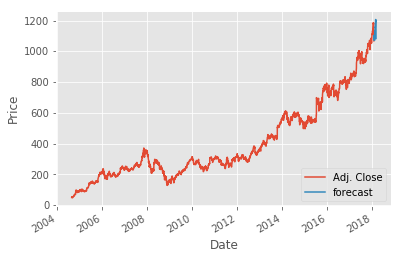

In [18]:
df['Adj. Close'].plot()
df['forecast'].plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [19]:
# pickling
import pickle